## Import Modules and Setup Environment

In [1]:
import polars as pl
from argmap.dataModel import Summary, Comments, Topics, HierarchicalTopics, Arguments, ArgumentCommentMap, Votes

from dotenv import load_dotenv
load_dotenv()

# this allows categorical data from various sources to be combined and handled gracefully; performance cost is acceptable
pl.enable_string_cache()

from IPython.display import display_markdown

DATASET = 'american-assembly.bowling-green'
# DATASET = 'scoop-hivemind.biodiversity'
# DATASET = 'scoop-hivemind.freshwater'
# DATASET = 'scoop-hivemind.taxes'
# DATASET = 'scoop-hivemind.ubi'
# DATASET = 'scoop-hivemind.affordable-housing'
# DATASET = 'london.youth.policing'
# DATASET = 'canadian-electoral-reform'
# DATASET = 'brexit-consensus'
# DATASET = 'ssis.land-bank-farmland.2rumnecbeh.2021-08-01'

summary = Summary(DATASET)
comments = Comments(DATASET).load_from_parquet()
votes = Votes(DATASET,'votes').load_from_csv()
topics = Topics(DATASET).load_from_parquet()
hierarchicalTopics = HierarchicalTopics(DATASET).load_from_parquet()
arguments = Arguments(DATASET).load_from_parquet()
argumentCommentMap = ArgumentCommentMap(DATASET).load_from_parquet()

display_markdown(f"""
### Dataset: {DATASET}
#### {summary.topic}
#### {summary.get('conversation-description')}
#### Full Report: [{summary.url}]({summary.url})
""", raw=True)


### Dataset: american-assembly.bowling-green
#### Improving Bowling Green / Warren County
#### What do you believe should change in Bowling Green/Warren County in order to make it a better place to live, work and spend time?
#### Full Report: [https://pol.is/9wtchdmmun](https://pol.is/9wtchdmmun)


## Data Analysis

In the following section, we analyze the relationship between human-generated statements and the corresponding AI-generated arguments.

### Distribution of Argument-Comment Relationship Types

Each Argument-Comment pair link can be SUPPORT, REFUTE, or UNRELATED. The following graph shows the distribution. Majority are unrelated as expected. A very small fraction of statements appear to refute any of the arguments.


In [ ]:
import seaborn as sns

sns.catplot(
    data=argumentCommentMap.df.get_column('relationship').value_counts(),
    x='relationship',
    y='count',
    kind='bar',
    height=3,
    aspect=4,
)

### Argument-Comment Mapping Distribution by Topic

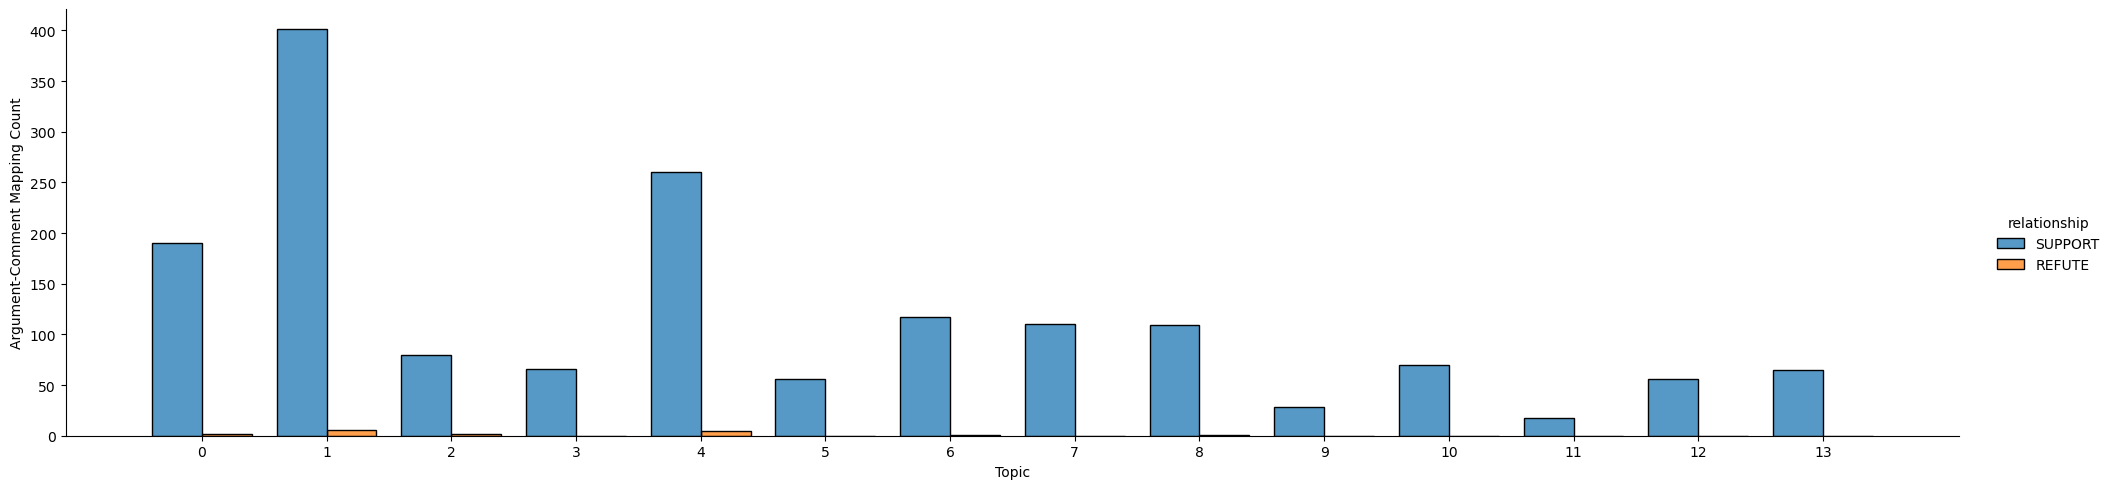

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

argumentCommentGridDf = (
    argumentCommentMap.df
    .filter(pl.col('relationship') != 'UNRELATED')
    .select(
        'argumentId',
        'topicId',
        commentId=pl.col('commentId').cast(pl.Utf8),
        relationship=pl.col('relationship').cast(pl.Utf8))
)

sns.displot(
    data=argumentCommentGridDf,
    x='topicId',
    element='bars',
    discrete=True,
    stat='count',
    hue='relationship',
    height=5,
    aspect=4,
    multiple='dodge',
    shrink=0.8,
)

plt.xlabel('Topic')
plt.ylabel('Argument-Comment Mapping Count')

# Add ticks on x-axis at every 1 step
plt.xticks(range(argumentCommentGridDf['topicId'].min(), argumentCommentGridDf['topicId'].max()+1, 1))

plt.show()

### Argument-Comment Mapping Distribution by Topic and Argument

Each topic contains roughly 5-10 arguments. The following graph shows the number of statements that either support or refute each argument within each topic.

The initial topics have more statements and thus a larger number of arguments. This distribution will likely skew the support towards the initial topics that are more heavily represented. In considering support for individual arguments, we should focus on metrics that normalize for this distribution. Use of `agreeability`, the ratio of agree votes to total votes, is preferred over the raw number of agree and disagree votes.

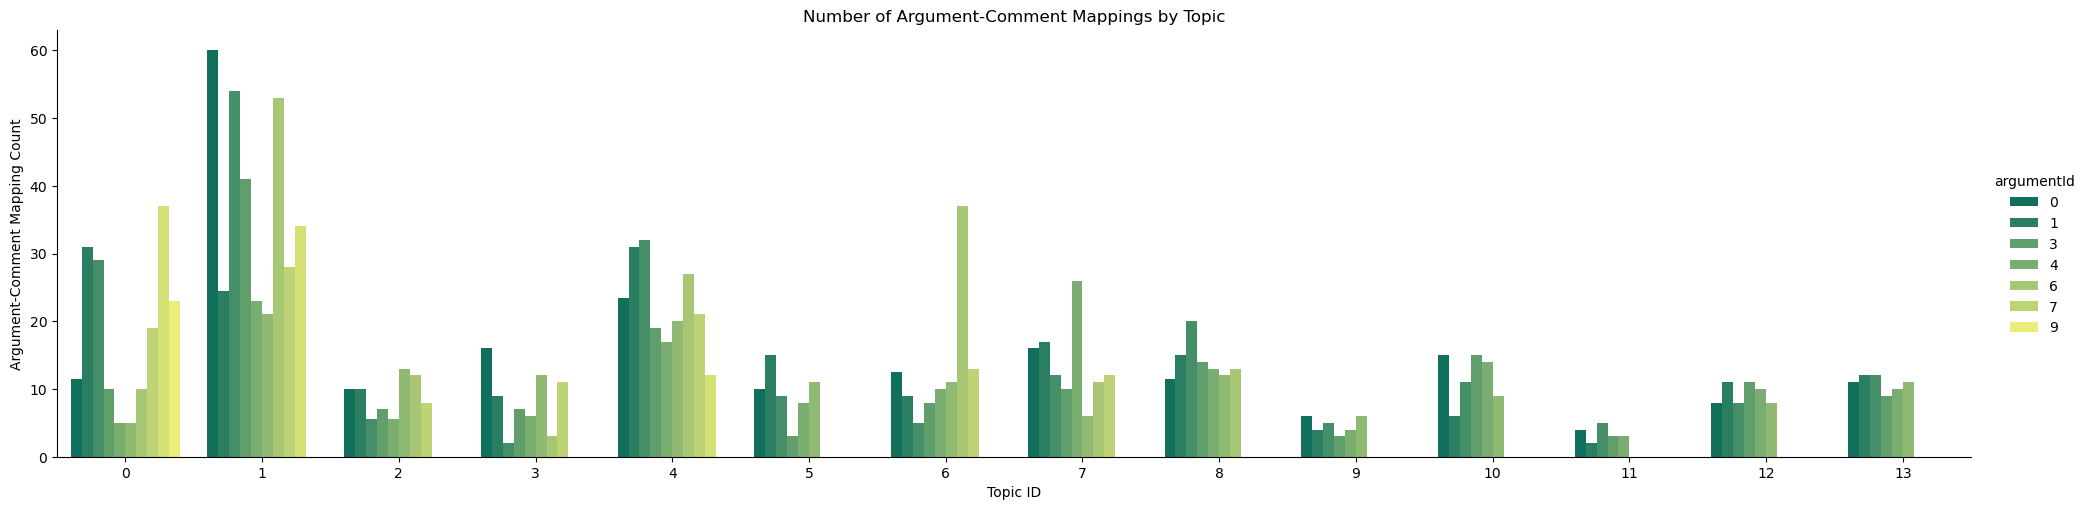

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

argumentCommentMapGroupedDf = (
    argumentCommentMap.df
    .filter(pl.col('relationship') != 'UNRELATED')
    .group_by('topicId', 'argumentId', 'relationship')
    .agg(pl.count('commentId').alias('count'))
    .with_columns(relationship=pl.col('relationship').cast(pl.Utf8))
)

sns.catplot(
    data=argumentCommentMapGroupedDf,
    x='topicId',
    y='count',
    hue='argumentId',
    kind='bar',
    errorbar=None,
    height=5,
    aspect=4,
    palette='summer',
)
plt.title('Number of Argument-Comment Mappings by Topic')
plt.xlabel('Topic ID')
plt.ylabel('Argument-Comment Mapping Count')
plt.show()

### Refuting Statements

Following is a sample of arguments and statements that the model labeled as REFUTE, along with the chain-of-thought reasoning that led to the decision.

In [14]:
argumentCommentMap.glimpse()

Rows: 4361
Columns: 5
$ commentId          <u16> 893, 890, 875, 839, 828, 827, 822, 813, 810, 790
$ topicId            <u16> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ argumentId         <u16> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ relationship       <cat> UNRELATED, UNRELATED, UNRELATED, UNRELATED, UNRELATED, SUPPORT, UNRELATED, UNRELATED, UNRELATED, REFUTE
$ reasoning    <list[str]> ['THOUGHT: The argument and statement are unrelated. The argument is about creating a funding source for homeless support services, while the statement is about providing free meeting space for nonprofits.'], ['THOUGHT: The statement does not directly address the issue of homelessness or the argument for an occupational tax to fund temporary housing and support services.'], ['THOUGHT: A person who agrees with the statement might see the argument as unrelated because it does not directly address the issue of deterioration in older neighborhoods due to rental conversions.'], ['THOUGHT: The statement and argument are not direct

In [17]:
for commentId, topicId, argumentId, topicTitle, argumentTitle, argumentContent, commentText, relationship, reasoning, agrees, disagrees in (
    argumentCommentMap.df.lazy()
    .cast({'topicId': pl.Int16}) # can remove this once all datasets are updated
    .filter(pl.col('relationship') == 'REFUTE')
    .with_columns(commentId = pl.col('commentId').cast(pl.UInt16))
    .join(arguments.df.lazy(), ['topicId', 'argumentId'], 'left')
    .join(comments.df.lazy(), 'commentId', 'left')
    .join(topics.df.lazy().select(topicId=pl.col('Topic'), topicTitle='Title'), 'topicId', 'left')
    .group_by('topicId').first()
    .sort('topicId')
    .select('commentId', 'topicId', 'argumentId', 'topicTitle', 'argumentTitle', 'argumentContent', 'commentText', 'relationship', 'reasoning', 'agrees', 'disagrees')
    ).collect().iter_rows():
    display_markdown(f"""\
#### {argumentTitle}

> TOPIC: {topicTitle}
>
> ARGUMENT: {argumentContent}
>
> COMMENT {commentId}: {commentText} (+{agrees}, -{disagrees}, {relationship})
>
> {reasoning[0]}

""", raw=True)

#### Occupational Tax for Homeless Support

> TOPIC: Implementing Occupational Taxes to Address Homelessness
>
> ARGUMENT: Implement a small occupational tax on businesses to fund temporary housing and support services for the homeless, creating a safer and more prosperous community for all.
>
> COMMENT 790: Many people want something for nothing and if they don't get it they steal it instead of working for it.  We are producing a gimme society. (+45, -38, REFUTE)
>
> THOUGHT: The statement seems to imply that people should work for what they want, and that those who don't work are a burden on society. The argument, on the other hand, suggests that businesses should pay a small tax to support the homeless, who are often perceived as not contributing to society. A person who agrees with the statement might see the argument as a form of "something for nothing" and therefore be against it.



#### Safer and More Convenient Roads

> TOPIC: Implementation of Traffic Control Measures to Improve Road Flow
>
> ARGUMENT: Widening roads and creating shoulders can significantly improve safety and convenience for drivers, providing more space for turning lanes and ensuring a smoother driving experience.
>
> COMMENT 530: The travesty going up on Fairview Ave. should never have been allowed (+24, -18, REFUTE)
>
> THOUGHT: A person who is against the construction on Fairview Ave. might not support the argument, as they may view the construction as the problem, not the lack of road width or shoulders.



#### Enhancing Aesthetic Appeal

> TOPIC: Opposition to the Proposed Fairness Ordinance in Bowling Green
>
> ARGUMENT: Enforcing zoning mandates will improve the aesthetic appeal of Bowling Green and maintain property values.
>
> COMMENT 622: There should be an actual complaint filed by a neighbor before Code Enforcement writes a violation. Stop harassing hardworking citizens. (+41, -29, REFUTE)
>
> THOUGHT: A person who agrees with the statement may not support the argument because they may view zoning mandates as harassment and an infringement on property rights.



#### Comprehensive City Planning and Zoning Strategy

> TOPIC: Implementing a Comprehensive City Planning and Zoning Strategy for Better Neighborhoods and Community Activities
>
> ARGUMENT: To make Bowling Green a better place to live, work, and spend time, it's crucial to implement a comprehensive city planning and zoning strategy that enforces historic preservation codes, supports local businesses, provides family-centered activities, allocates resources equitably, and focuses on mixed-use development and renovations.
>
> COMMENT 416: Too many apartments in Plano. Nice little country setting I bought my home in forever ruined! (+47, -41, REFUTE)
>
> THOUGHT: A person who agrees with the statement may feel that the city planning strategy is not addressing their concern about too many apartments in Plano.



#### Essential Education Funding

> TOPIC: The Importance of Adequate Funding and Accountability in Public School Education
>
> ARGUMENT: Increased funding for public schools, especially art education programs, is essential to fostering a well-rounded education for students.
>
> COMMENT 17: If private schools were to get a share of Federal or State education dollars, it would hurt public schools. (+427, -205, REFUTE)
>
> THOUGHT: A person who agrees with the statement would likely not support the argument, as they believe that increased funding for public schools would come at the expense of private schools.



#### Enhancing Park Experience

> TOPIC: Implementation of Pedestrian-Friendly Infrastructure in Key Areas
>
> ARGUMENT: Implementing pedestrian-friendly infrastructure in sports-centric parks can enhance the overall park experience and promote healthier lifestyle choices.
>
> COMMENT 378: More sidewalks would be great, but first let’s stop people parking on them.  Or stop spending money building them.  Whichever. (+68, -24, REFUTE)
>
> THOUGHT: The user seems to be in favor of pedestrian-friendly infrastructure, but they are concerned about people parking on sidewalks and the misuse of funds.



#### Utility of Refute Relationships

The above list of arguments indicates that the model typically labels the statements as REFUTE accurately but does misconstrue some statements and deduces the relationship incorrectly. For example, consider the following:

> TOPIC: The Importance of Adequate Funding and Accountability in Public School Education
>
> ARGUMENT: Increased funding for public schools, especially art education programs, is essential to fostering a well-rounded education for students.
>
> COMMENT 17: If private schools were to get a share of Federal or State education dollars, it would hurt public schools. (+427, -205, REFUTE)

While the argument is about increased funding for public schools, the comment is about private schools getting funding from tax dollars. The argument and comment are tangentially related but do not advocate for or against the same thing. The model should have labeled this as UNRELATED. This can be optimized by additional chain-of-thought reasoning but is beyond the scope of this study.

For the purpose of this study, we will ignore the REFUTE relationships and focus on the SUPPORT relationships.

## Calculating Support Per Argument

At this point we know which comments support or refute each argument. Now we count the number of people that agree or disagree with each argument. Then we determine the overall support for each argument. In this process, we need to consider the following skewing factors:

- Votes per statement - those posted later get fewer votes
- Some topics and arguments have more statements than others
- Some people vote more than others (risk of loud minority)
- Individual agree/disagree tendencies (e.g. individual agreeing with everything)

We can employ the following techniques to determine the overall support for each argument.

- Aggregate agree and disagree votes
- Count participants that agree vs disagree
- Normalize each statement's weight by its agreeability
- Normalize each person's vote by their tendency to agree or disagree
- Consider number of statements that support each argument - perhaps filter out arguments with fewer than a certain number of supporting statements
- Argument Agreeability based on individual voting patterns
- Argument Support based on supporting statements
- Count agree votes * agreeability of each statement. Here we might disregard the disagree votes but weigh them in through the agreeability factor.
- Normalize each person's vote by their tendency to agree or disagree
- Normalize each person's vote by the total fraction of votes they cast

More sophisticated analysis would involve finding arguments where people tend to both agree and disagree with their supporting statements, and flagging those arguments for further review.

### Argument Support by Associated SUPPORT Statements

In [24]:
argumentSupportByComment = (
    argumentCommentMap.df.lazy()
    .cast({'topicId': pl.Int16}) # can remove this once all datasets are updated
    .filter(pl.col('relationship') == 'SUPPORT')
    .join(votes.df.lazy().filter(pl.col('vote') != 0), 'commentId', 'inner')
    .select('topicId', 'argumentId', 'commentId', 'voterId', 'vote')
).collect()

argumentSupportByComment.glimpse()

Rows: 453386
Columns: 5
$ topicId    <i16> 5, 5, 5, 4, 4, 4, 4, 4, 4, 4
$ argumentId <u16> 0, 2, 5, 0, 1, 2, 3, 4, 5, 6
$ commentId  <u16> 19, 19, 19, 18, 18, 18, 18, 18, 18, 18
$ voterId    <u16> 0, 0, 0, 2, 2, 2, 2, 2, 2, 2
$ vote        <i8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1



### Argument Support by Individual Voters

In [25]:
argumentSupportByVoter = (
    argumentSupportByComment.lazy()
    .group_by(['topicId', 'argumentId', 'voterId'])
    .agg(vote=pl.sum('vote'))
    .with_columns(
        vote=(
            pl.when(pl.col('vote') > 0).then(1)
            .when(pl.col('vote') < 0).then(-1)
            .otherwise(0)
        ),
        agree=pl.col('vote') > 0,
        disagree=pl.col('vote') < 0,
    )
).collect()

# change each vote to a 1 if it's positive, -1 if it's negative, and 0 if it's neutral

argumentSupportByVoter.glimpse()

Rows: 109074
Columns: 6
$ topicId     <i16> 0, 0, 11, 4, 11, 5, 7, 6, 8, 8
$ argumentId  <u16> 6, 9, 3, 5, 2, 3, 1, 5, 1, 5
$ voterId     <u16> 2, 8, 8, 12, 21, 24, 26, 24, 27, 27
$ vote        <i32> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ agree      <bool> True, True, True, True, True, True, True, True, True, True
$ disagree   <bool> False, False, False, False, False, False, False, False, False, False



### Argument Support Metrics 

Calculating support for each argument in terms of agree / disagree votes and `agreeability`, defined as the ratio of agree votes to total votes.

In [26]:
# count the agree and disagree votes for each argument

argumentSupport = (
    argumentSupportByVoter
    .group_by('topicId', 'argumentId')
    .agg(
        support=pl.sum('vote'),
        agrees=pl.sum('agree'),
        disagrees=pl.sum('disagree'),
    )
    .with_columns(
        agreeability=pl.col('agrees') /
        (pl.col('agrees') + pl.col('disagrees')),
    )
    .sort('agreeability', descending=True)
)

argumentSupport.glimpse()

Rows: 102
Columns: 6
$ topicId      <i16> 10, 10, 10, 10, 10, 10, 1, 1, 6, 1
$ argumentId   <u16> 3, 4, 0, 1, 2, 5, 5, 4, 4, 0
$ support      <i32> 1065, 1056, 1058, 856, 908, 891, 1091, 1109, 765, 1115
$ agrees       <u32> 1129, 1120, 1123, 912, 971, 953, 1182, 1204, 836, 1220
$ disagrees    <u32> 64, 64, 65, 56, 63, 62, 91, 95, 71, 105
$ agreeability <f64> 0.9463537300922046, 0.9459459459459459, 0.9452861952861953, 0.9421487603305785, 0.9390715667311412, 0.9389162561576355, 0.9285153181461115, 0.9268668206312548, 0.9217199558985667, 0.9207547169811321



### Argument Support Metrics combined with argument and topic details

In [27]:
argumentTopicSupport = (
    argumentSupport.lazy()
    .join(arguments.df.lazy(), ['topicId', 'argumentId'], 'left')
    .join(topics.df.lazy().select(topicId=pl.col('Topic'), topicTitle='Title'), 'topicId', 'left')
    .sort('agreeability', descending=True)
).collect()

argumentTopicSupport.glimpse()

Rows: 102
Columns: 10
$ topicId               <i16> 10, 10, 10, 10, 10, 10, 1, 1, 6, 1
$ argumentId            <u16> 3, 4, 0, 1, 2, 5, 5, 4, 4, 0
$ support               <i32> 1065, 1056, 1058, 856, 908, 891, 1091, 1109, 765, 1115
$ agrees                <u32> 1129, 1120, 1123, 912, 971, 953, 1182, 1204, 836, 1220
$ disagrees             <u32> 64, 64, 65, 56, 63, 62, 91, 95, 71, 105
$ agreeability          <f64> 0.9463537300922046, 0.9459459459459459, 0.9452861952861953, 0.9421487603305785, 0.9390715667311412, 0.9389162561576355, 0.9285153181461115, 0.9268668206312548, 0.9217199558985667, 0.9207547169811321
$ argumentTitle         <str> 'Driving Competition and Improving Services', 'Improving Internet Speeds and Competition', 'Driving Competition and Improving Internet Access', 'Ensuring Fair Cable TV Services', 'Bridging the Digital Divide', 'Bridging the Digital Divide through Free WiFi', 'Improved Traffic Flow', 'Improved Access and Service Roads', 'Comprehensive Sex Education', 'Im

## List of Strongest Arguments

In [31]:
for topicId, topicTitle, argumentId, argumentTitle, argumentContent, support, agreeability, agrees, disagrees in (
    argumentSupport.lazy()
    .sort('agreeability', descending=True)
    .group_by('topicId', maintain_order=True).head(2)
    .join(arguments.df.lazy(), ['topicId', 'argumentId'], 'left')
    .join(topics.df.lazy().select(topicId=pl.col('Topic'), topicTitle='Title'), 'topicId', 'left')
    .select('topicId', 'topicTitle', 'argumentId', 'argumentTitle', 'argumentContent', 'support', 'agreeability', 'agrees', 'disagrees')
    .sort('agreeability', descending=True)
    ).collect().iter_rows():
    display_markdown(f"""\
#### {argumentTitle} (+{agrees}, -{disagrees}, {agreeability*100:.1f}%)

TOPIC: {topicTitle}

{argumentContent}

""", raw=True)

#### Driving Competition and Improving Services (+1129, -64, 94.6%)

TOPIC: Expansion of Residential Internet Services in Bowling Green

Increasing competition for cable and internet companies will drive down rates, improve services, and provide more fiber options for Bowling Green residents.



#### Improving Internet Speeds and Competition (+1120, -64, 94.6%)

TOPIC: Expansion of Residential Internet Services in Bowling Green

Making fiber internet options available will improve internet speeds, drive down rates, and promote competition for cable and internet companies in Bowling Green.



#### Improved Traffic Flow (+1182, -91, 92.9%)

TOPIC: Implementation of Traffic Control Measures to Improve Road Flow

Reducing the number of traffic lights and implementing roundabouts can significantly improve traffic flow, ensuring a smoother driving experience for drivers.



#### Improved Access and Service Roads (+1204, -95, 92.7%)

TOPIC: Implementation of Traffic Control Measures to Improve Road Flow

Proper planning and improvement of service roads and access roads can significantly improve safety and convenience for drivers, reducing traffic jams and ensuring a smoother driving experience.



#### Comprehensive Sex Education (+836, -71, 92.2%)

TOPIC: The Importance of Adequate Funding and Accountability in Public School Education

Comprehensive sexual education is necessary to lower STD and teen pregnancy rates.



#### Clean Yards (+629, -61, 91.2%)

TOPIC: Implementing Improved Recycling and Waste Management Services in Bowling Green

Enforcing cleanliness and reducing junk cars can significantly improve the appearance of Bowling Green.



#### Deter Littering (+629, -61, 91.2%)

TOPIC: Implementing Improved Recycling and Waste Management Services in Bowling Green

Implementing fines can deter littering and illegal dumping, promoting a cleaner and safer environment.



#### Term Limits for Fair Representation (+861, -90, 90.5%)

TOPIC: Implementing Occupational Taxes to Address Homelessness

Implement term limits for local elected officials to promote fair representation, prevent misuse of power, and encourage fresh perspectives.



#### Modernizing Emergency Services (+626, -68, 90.2%)

TOPIC: Implementing Water and Fire Protection Measures in Warren County's Tuckertown Area

Upgrading volunteer fire departments will better equip them to serve the growing population and ensure the safety of Warren County residents.



#### Physical Activity for Health (+476, -53, 90.0%)

TOPIC: The Importance of Adequate Funding and Accountability in Public School Education

Daily physical activity in schools is vital to combating childhood obesity and promoting healthy lifestyles.



#### Historic Preservation and Unique Architectural Heritage (+1081, -128, 89.4%)

TOPIC: Implementing a Comprehensive City Planning and Zoning Strategy for Better Neighborhoods and Community Activities

Preserving historic homes and buildings, and maintaining unique architectural heritage are essential for fostering a strong sense of community, celebrating Bowling Green's rich history, and enhancing the city's overall appeal.



#### Enhancing Safety and Quality of Life (+721, -87, 89.2%)

TOPIC: Implementing Water and Fire Protection Measures in Warren County's Tuckertown Area

Extending water lines and implementing fire protection in the Tuckertown area will significantly improve safety and quality of life for residents, while reducing insurance costs.



#### Equitable Resource Distribution (+1216, -152, 88.9%)

TOPIC: Implementing a Comprehensive City Planning and Zoning Strategy for Better Neighborhoods and Community Activities

Ensuring equitable distribution of resources across all areas of the city is vital for fostering a more inclusive and thriving community, where every resident has access to essential amenities and opportunities.



#### Enhancing Aesthetic Appeal (+829, -107, 88.6%)

TOPIC: Opposition to the Proposed Fairness Ordinance in Bowling Green

Enforcing zoning mandates will improve the aesthetic appeal of Bowling Green and maintain property values.



#### Improving Downtown Pedestrian Experience (+1042, -162, 86.5%)

TOPIC: Implementation of Pedestrian-Friendly Infrastructure in Key Areas

Making downtown a pedestrian-friendly mall can significantly enhance the overall pedestrian experience and promote local businesses.



#### Improving Pedestrian Safety (+1045, -168, 86.2%)

TOPIC: Implementation of Pedestrian-Friendly Infrastructure in Key Areas

Installing sidewalks in areas with heavy pedestrian traffic can significantly improve pedestrian safety and accessibility.



#### Parking Regulation Enforcement (+617, -101, 85.9%)

TOPIC: Implementing a Comprehensive Parking and Food Assistance Program for College Students on Campus

Monitoring and enforcing parking regulations and handicap spaces will ensure fair access to parking and promote safety within the community.



#### Improved daily commuting (+911, -153, 85.6%)

TOPIC: Enhanced Public Transportation System for Accessible Daily Commute

Expanding the public transportation system's service area, increasing accessibility, and adding more stops in residential areas will greatly improve daily commuting for those without cars.



#### Improved Nashville Airport transport (+911, -153, 85.6%)

TOPIC: Enhanced Public Transportation System for Accessible Daily Commute

Providing regular and affordable daily transport to Nashville Airport will greatly benefit both residents and visitors.



#### Educated and Cultured Community (+1099, -186, 85.5%)

TOPIC: Bowling Green Community Enrichment Center: A Multi-Purpose Hub for Sports, Arts, and Learning

Increasing the number of cultural and educational establishments would promote learning, personal growth, and community development.



#### Downtown Parking Improvement (+651, -111, 85.4%)

TOPIC: Implementing a Comprehensive Parking and Food Assistance Program for College Students on Campus

Improving downtown parking and accessibility by increasing parking spaces, making reserved spaces available during evenings, and enforcing parking regulations will benefit existing businesses and their customers.



#### Diversity in City/County Government (+1127, -202, 84.8%)

TOPIC: Implementing Occupational Taxes to Address Homelessness

Promote racial and ethnic diversity in city/county government to enhance representation, recruitment, and growth.



#### Engaged University-Community Partnership (+963, -178, 84.4%)

TOPIC: Bowling Green Community Enrichment Center: A Multi-Purpose Hub for Sports, Arts, and Learning

Fostering cooperation between WKU and Bowling Green would enhance learning experiences, promote community engagement, and prepare students for their future careers.



#### Improve medical care access (+781, -156, 83.4%)

TOPIC: The Role of Doctors and Teenagers in the Opioid Crisis

Ensuring timely access to medical care, including appointments and healthcare facilities, is crucial to alleviate suffering and prevent health conditions from worsening.



#### Enforcing Noise Ordinances (+664, -138, 82.8%)

TOPIC: Opposition to the Proposed Fairness Ordinance in Bowling Green

Enforcing noise ordinances and codes will maintain peace and order in residential areas, ensuring a more enjoyable living experience for all Bowling Green residents.



#### Implement stricter opioid regulations (+855, -198, 81.2%)

TOPIC: The Role of Doctors and Teenagers in the Opioid Crisis

Enacting stricter regulations for opioid drugs and expanding mental health treatment access will help mitigate the opioid crisis and its devastating consequences.



#### Healthier Environment (+233, -94, 71.3%)

TOPIC: Legalized Marijuana: A Revenue-Generating Solution for Bowling Green

Implement policies to prohibit smoking in public parks and within 25 feet of businesses to address the concerns of 70% and 68% of voters, respectively, promoting a healthier environment.



#### Voter Support (+658, -342, 65.8%)

TOPIC: Legalized Marijuana: A Revenue-Generating Solution for Bowling Green

Pass a resolution in support of medical cannabis to address the needs of 60% of voters and enhance the quality of life in Bowling Green.

